<img src="cryotempo_logo.png" alt="logo" width="200"/> <img src="esa_logo.png" alt="esa" width="170"/> <img src="earthwave_logo.png" alt="earthwave" width="150"/> <img src="UoE_logo.png" alt="uoe" width="200"/>

##<strong>*This is a Jupyter notebook that demonstrates how to download and use Cryotempo-EOLIS data, downloaded from cs2eo.org. Here, we will investigate the coverage and quality of the point product*</strong> 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


To run this notebook, you will need to make sure that the folllowing packages are installed in your python environment (all can be installed via pip/conda). If you are using the Google Colab environment, these packages are already installed.

    - matplotlib
    - pandas: for dataframe manipulation
    - netCDF4: for handing NetCDF files
    - glob
    - datetime: for handling timestamps
    - dateutil: for timseries generation
    - numpy

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

###<strong>1) Download Data

Regardless of whether you are using the Google Colab environment, or have downloaded this notebook to your local drive, you will first need to download some data. You can use this notebook to plot any CryoTEMPO-EOLIS point data that you choose. For a quick example, follow the below instructions to download a small example dataset.</strong>

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

Imports necessary to run the rest of the code

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc
import glob
import datetime
from dateutil.relativedelta import *
import numpy as np
import matplotlib.dates as mdate
import os
from ftplib import FTP

plt.rcParams.update({'font.size': 16})

<strong>The following four cells contain the python script necessary to download the results of the query described above from the ESA FTP servers. It is taken verbatim from the script generated by a cs2eo query - one could run said script in place of these 4 cells, for any query of your choice. The data is downloaded to your current working directory. This query will a file containing point product data for and area of Greenland that includes the Jakobshavn glacier.</strong>

This function is necessary to complete the data download

In [2]:
def file_byte_handler(data):
    global download_file_obj, read_byte_count, total_byte_count
    download_file_obj.write(data)
    read_byte_count = read_byte_count + len(data)

First, we list the files that we want to download. These are generated automatically by a [cs2eo.org](https://cs2eo.org/cryotempo) query. If you wanted to download additional months or a different region, you would add the corresponding file paths to this list.

In [3]:
esa_files =  ['/TEMPO_SWATH_POINT/2021/03/GREENLAND/CS_OFFL_THEM_POINT_GREENLAND_2021_03_-200000___-2300000__V001.nc']
download_file_obj = None
read_byte_count = None
total_byte_count = None

Next, we must provide an email address to access the ESA FTP server. Input your email into the prompt that appears below.

In [4]:
email = input("Please enter your e-mail: ")

Finally, we connect to the server, supply our email address and download the data to our current working directory. This process should take a couple of minutes. The progress of the download will be shown below.

In [5]:
print("About to connect to ESA science server")
# Open the FTP connection
with FTP("science-pds.cryosat.esa.int") as ftp:
    try:
        #Login using your email address
        ftp.login("anonymous", email)
        print("Downloading {} files".format(len(esa_files)))
        # Step through the files that we want to download    
        for i, filename in enumerate(esa_files):
            padded_count = str(i+1).zfill(len(str(len(esa_files))))
            # Print some details about the progress of the download
            print("{}/{}. Downloading file {}".format(padded_count, len(esa_files), os.path.basename(filename)))
            with open(os.path.basename(filename), 'wb') as download_file:
                download_file_obj = download_file
                total_byte_count = ftp.size(filename)
                read_byte_count = 0
                ftp.retrbinary('RETR ' + filename, file_byte_handler, 1024)
            print("\n")
    # After downloading all of the files, close the FTP connection
    finally:
        print("Exiting FTP.")
        ftp.quit()

About to connect to ESA science server
01/13. Downloading file CS_OFFL_THEM_POINT_GREENLAND_2021_09_-200000___-2300000__V002.nc
  [============================================================] 100 % 

02/13. Downloading file CS_OFFL_THEM_POINT_GREENLAND_2022_03_-200000___-2300000__V003.nc
  [============================================================] 100 % 

03/13. Downloading file CS_OFFL_THEM_POINT_GREENLAND_2021_08_-200000___-2300000__V002.nc
  [============================================================] 100 % 

04/13. Downloading file CS_OFFL_THEM_POINT_GREENLAND_2021_10_-200000___-2300000__V002.nc
  [============================================================] 100 % 

05/13. Downloading file CS_OFFL_THEM_POINT_GREENLAND_2021_12_-200000___-2300000__V002.nc
  [============================================================] 100 % 

06/13. Downloading file CS_OFFL_THEM_POINT_GREENLAND_2022_05_-200000___-2300000__V002.nc
  [===========================================================

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
###<strong>2) Load downloaded data into python</strong>

<strong>Now that we have downloaded the data, we can use python to visualise it. In the remainder of this demo notebook, we will load the data that we have just downloaded into python, and use it to investigate the coverage and quality of the CryoTEMPO-EOLIS point prodcut over the Jakobshavn glacier.</strong> 

If you have downloaded the notebook onto your local machine, you will need to edit the filepath below to point to the location of the downloaded data. We will then locate and store the names of each of the point data files. The point data is stored in *netcdf* files, which have the suffix '.nc'.

In [14]:
data_filepath = '/content/' #Filepath specific to the Google Colab environment
files = sorted(glob.glob(data_filepath+'/*.nc'))

<strong>Now that the files containing the data have been located, we will load the data that they contain into python, one file at a time.</strong> 


In [15]:
list_of_dataframes_from_netcdfs = []

Firstly, we can check the metadata for the point product files. In the output of this command, we can see lots of additional information assosciated with the point product files, including projection information, product version and support information.

In [16]:
dataset = nc.Dataset(files[0])
print(dataset)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    cdm_data_type: Point
    Conventions: CF-1.7
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    comment: Point file containing elevation estimates
    contact: support@cryotempo-eolis.org
    creator_email: support@cryotempo-eolis.org
    creator_url: http://cryotempo-eolis.org/
    date_created: 2021-08-07T23:35:44.754103
    date_modified: 2021-08-07T23:35:44.754120
    DOI: 10.5270/CR2-2xs4q4l
    geospatial_y_min: -2299999.603829329
    geospatial_y_max: -2200000.016745909
    geospatial_x_min: -199998.59943888301
    geospatial_x_max: -131117.01803819623
    geospatial_y_units: metres
    geospatial_x_units: metres
    geospatial_projection: +proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs
    institution: ESA, UoE, Earthwave, isardSAT 
    keywords: Land Ice > Elevation Model  > Elevation Points > Swath Processing > CryoSat2 
    keyword

The following code opens each netcdf file, reads in the data associated with each variable, and stores this data in the column of a dataframe. The loop below does this for all of the point data files in our current directory.

In [17]:
for i in range(len(files)):
    data = {}
    with nc.Dataset(files[i]) as netcdf:
        for column in netcdf.variables:
            rows_from_nc = netcdf.variables[column]
            data[column] = pd.Series(rows_from_nc[:])
    df = pd.DataFrame(data)        
    list_of_dataframes_from_netcdfs.append(df)

After loading in the data from each individual file returned by the point product query, we combine them into one dataframe. 

In [18]:
full_query_results = pd.concat(list_of_dataframes_from_netcdfs)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
###<strong>3. Investigate the point product</strong>

<strong>Now that the data has been loaded into the notebook, and stored in a dataframe, we can create some visuals that allow us to quickly understand the scope of the point product and its capabilities.</strong>

If we run the cell below, we can see the total number of points in the data. Additionally, the variables available for analysis include a time, x and y position, elevation and an associated uncertainty value. For more information about the derivation of these variables, see the CryoTEMPO-EOLIS ATBD, available at https://cryotempo-eolis.org/product-description/

In [19]:
# Dataframe meta data that describes results of query
print('Number of points in query =', len(full_query_results))
print('Variables returned by query: ', full_query_results.columns)

Number of points in query = 1647427
Variables returned by query:  Index(['time', 'x', 'y', 'elevation', 'uncertainty', 'isSwath', 'inputfileid'], dtype='object')


Next, we make a simple spatial plot of the point product that we have downloaded. This plot shows all point data available for the Jakobshavn glacier in the timeframe that we specified for the query, and demonstrates the spatial coverage achieved using swath processing. In the Figure on the left, the scatter points are colour-coded by their elevations. On the right, the colour demonstrates the uncertainty associated with each point. For more information on the observing tracks of CryoSat and swath processing, see https://earth.esa.int/eogateway/news/cryosats-swath-processing-technique

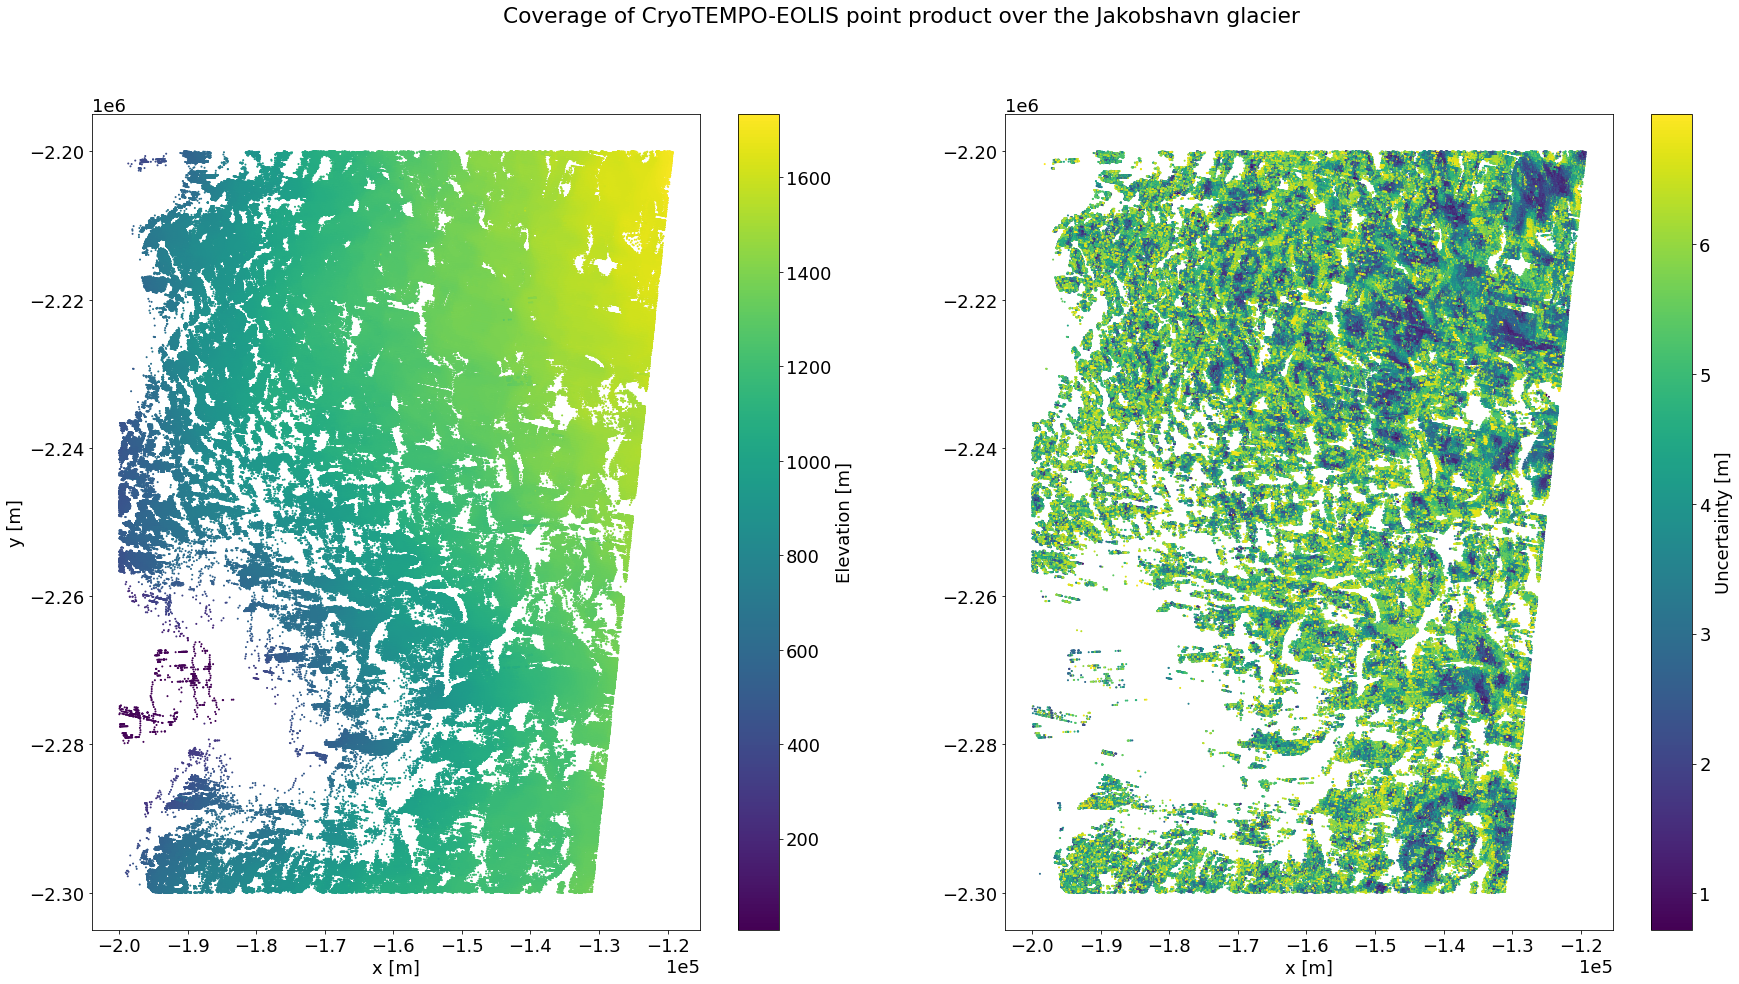

In [33]:
fig, axs = plt.subplots(1,2,figsize=(30,15), sharex=True)

c = axs[0].scatter(full_query_results['x'], full_query_results['y'], c=full_query_results['elevation'], s=1, cmap='viridis')
plt.colorbar(c, ax = axs[0], label='Elevation [m]')
u = axs[1].scatter(full_query_results['x'], full_query_results['y'], c=full_query_results['uncertainty'], s=1, cmap='viridis')
plt.colorbar(u, ax = axs[1], label='Uncertainty [m]')

axs[0].set_xlabel('x [m]')
axs[1].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
t = plt.suptitle('Coverage of CryoTEMPO-EOLIS point product over the Jakobshavn glacier')

<strong> Next, we can calculate some data quality statistics. </strong>

Firstly we calculate the mean and median uncertainties, as well as the standard deviation.

In [34]:
mean_unc = np.nanmean(full_query_results['uncertainty'])
med_unc = np.nanmedian(full_query_results['uncertainty'])
std_unc = np.std(full_query_results['uncertainty'])

We next set up some histogram bins, requiring 40 bins in the uncertainty range.

In [35]:
bins = np.linspace(np.nanmin(full_query_results['uncertainty']),np.nanmax(full_query_results['uncertainty']),40)

Finally, we plot a histogram of the uncertainty values for this point product dataset, and display the mean and median values, as well as the standard deviation of uncertainties.

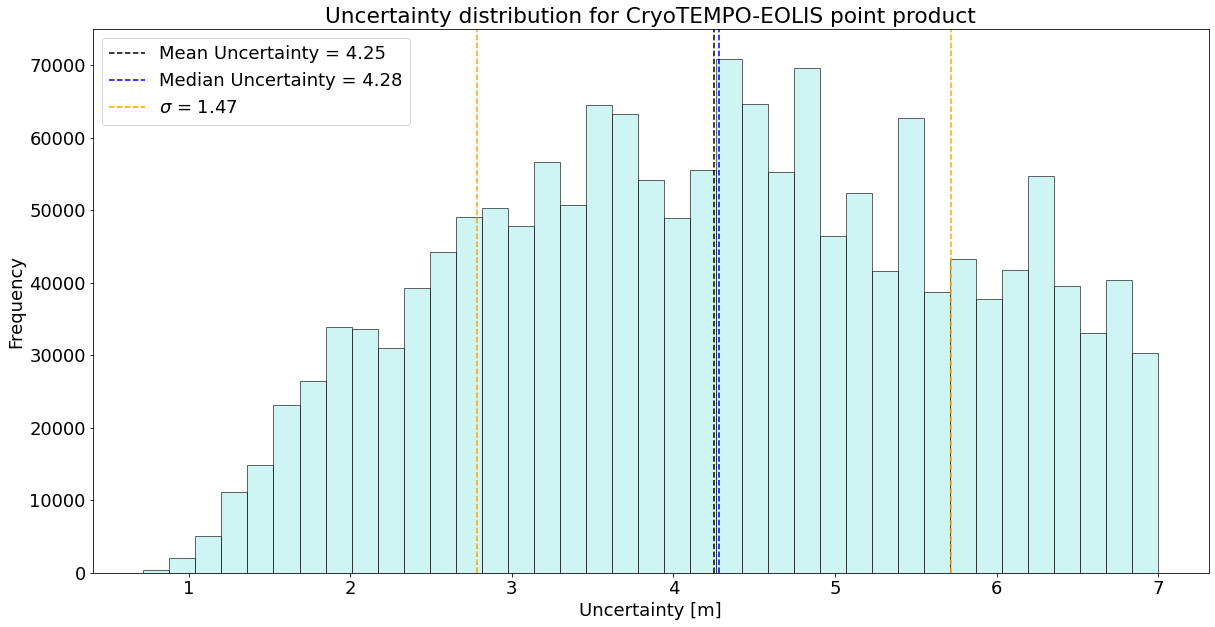

In [36]:
fig, axs = plt.subplots(1,1,figsize=(20,10))

a = axs.hist(full_query_results['uncertainty'], bins = bins, facecolor='paleturquoise', edgecolor='k', alpha=0.6)

axs.vlines(mean_unc, 0, 7.5e4, color='k', linestyle='dashed', label='Mean Uncertainty = {:0.2f}'.format(mean_unc))
axs.vlines(med_unc, 0, 7.5e4, color='b', linestyle='dashed', label='Median Uncertainty = {:0.2f}'.format(med_unc))
axs.vlines(mean_unc - std_unc, 0,7.5e4, color='orange', linestyle='dashed')
axs.vlines(mean_unc + std_unc, 0,7.5e4, color='orange', linestyle='dashed',label='$\sigma$ = {:0.2f}'.format(std_unc))

axs.set_ylim(0, 7.5e4)
axs.set_xlabel('Uncertainty [m]')
axs.set_ylabel('Frequency')
axs.set_title('Uncertainty distribution for CryoTEMPO-EOLIS point product')
plt.legend()